# Weekly LAI data:  processing

**Contents:**

1. Detrend the timeseries with `CDO`
2. Extract seasonal component
  1. With `CDO`
  2. With `xarray` 
3. Calculate residuals


## Introduction

In [1]:
import os
import time
import datetime
import random as rd
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline

Change the filepath to the path containing the LAI netcdf file:

In [2]:
filepath = '/home/stijndc/Desktop/datafiles/SAT_EX/netcdf files/' 

Read in the file, apply the scaling factor and extract the LAI, latitude, longitude and timestamps:

In [3]:
LAI_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI.AVHRR.V004.1982-2015_1.nc'),
                     'r', format='NETCDF3')

LAI = LAI_netcdf.variables['LAI'][::]
LAI = LAI[:,::-1,:]

lat = LAI_netcdf.variables['lat'][::-1]
lon = LAI_netcdf.variables['lon'][:]
timestamps = LAI_netcdf.variables['time'][:]

In [4]:
LAI_netcdf

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions: CF-1.4
    history: Tue Feb 21 19:23:55 2017: cdo -P 4 remapbil,/media/Matthias_2/data/cmip5/griddata/1_GHCN_grid /media/Matthias_2/data/cmip5/OBS/Vegetation/GLASSLAI2/nc/GLASSLAI.AVHRR.V004.1982.nc /media/Matthias_2/data/cmip5/OBS/Vegetation/GLASSLAI2/nc/GLASSLAI.AVHRR.V004.1982_1.nc
Tue Feb 21 19:15:09 2017: cdo -P 4 -b F64 mulc,0.01 /media/Matthias_2/data/cmip5/OBS/Vegetation/GLASSLAI2/tmp/tmp2.nc /media/Matthias_2/data/cmip5/OBS/Vegetation/GLASSLAI2/tmp/tmp3.nc
Tue Feb 21 19:15:07 2017: cdo -P 4 setvrange,0,1200 /media/Matthias_2/data/cmip5/OBS/Vegetation/GLASSLAI2/tmp/tmp1.nc /media/Matthias_2/data/cmip5/OBS/Vegetation/GLASSLAI2/tmp/tmp2.nc
Tue Feb 21 19:15:07 2017: ncatted -O -a fill_value,LAI,d,, /media/Matthias_2/data/cmip5/OBS/Vegetation/GLASSLAI2/tmp/tmp1.nc
Tue Feb 21 19:15:07 2017: ncatted -O -

Let's look at a couple of randomly sampled pixels:

In [5]:
def show_timeseries(ndarr, ts, color='#1b7837', reproduce=True):
    """
    Randomly sample 15 pixels, plot LAI time series. 
    If a pixel with missing data is sampled, resample. 
    
    Arguments:
    ndarr: 3d ndarray from netcdf file
    ts: ndarray, unix timestamps
    reproduce: fix seed if True
    """
    
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
    if reproduce:
        rd.seed(42) # set seed to sample the same pixels everytime
    for axrow in axes:
        for ax in axrow:

            # choose random pixel, resample if it's a sea pixel
            i, j = rd.randint(0, ndarr.shape[1]-1), rd.randint(0, ndarr.shape[2]-1)
           
            while(ndarr.mask[0,i,j]):
                i, j = rd.randint(0, ndarr.shape[1]-1), rd.randint(0, ndarr.shape[2]-1)
            # plot image
            temp = pd.Series(ndarr[:, i,j], index=ts)
            temp.plot(ax=ax, kind='line', color=color, 
                     sharex=True, sharey=True)
            # add title
            ax.set_title('Lat {}, Lon {}'.format(lat[i],lon[j]))

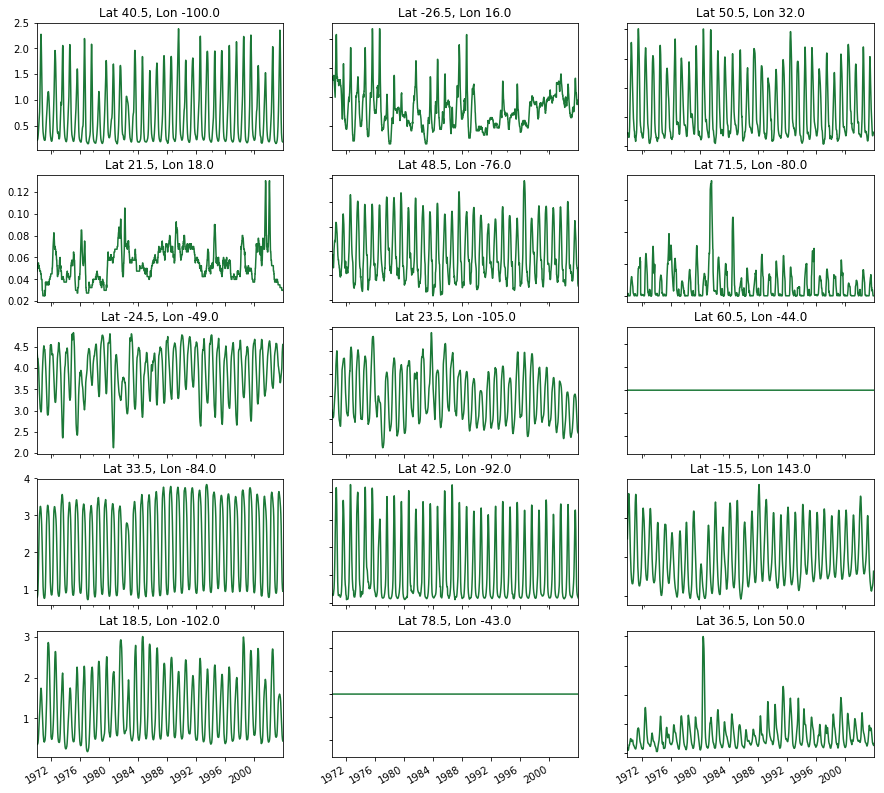

In [6]:
show_timeseries(LAI, ts=pd.to_datetime(timestamps, unit='d'), reproduce=True)

# 1. Detrend the time series

The LAI time series are certainly not stationary all around the globe. Let's remove the trend with
[cdo](https://code.zmaw.de/projects/cdo/embedded/index.html#x1-5310002.10.2):

`cdo trend infile afile bfile
cdo subtrend infile afile bfile outfile`

First, let's have a look at some detrended timeseries:

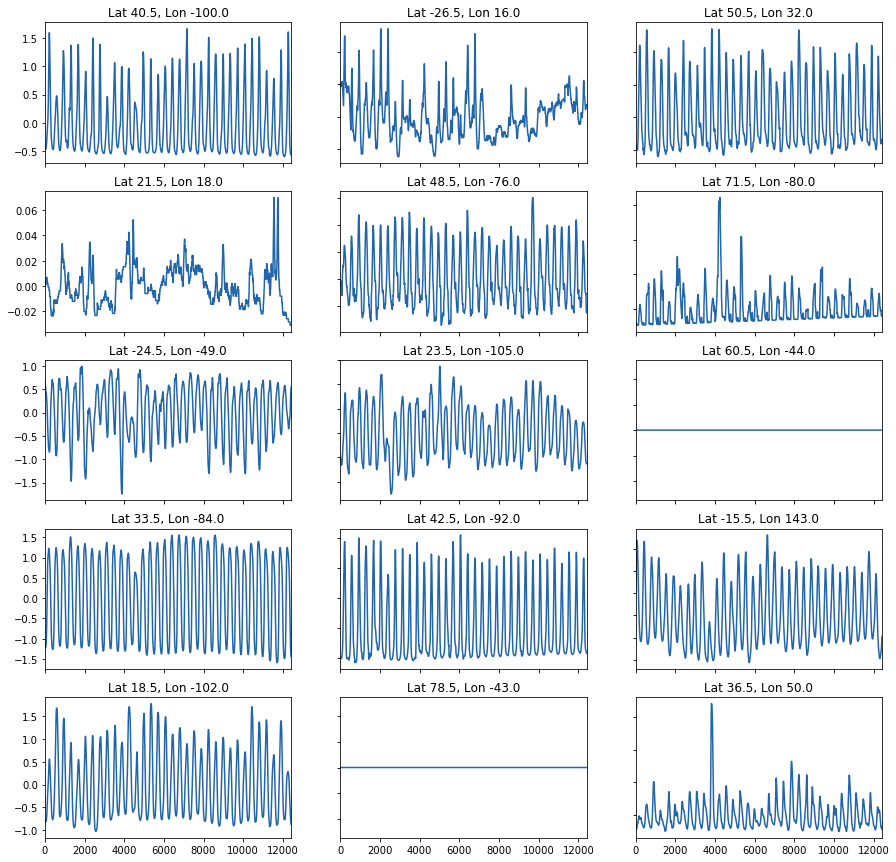

In [7]:
LAI_detrend_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI_DETREND.nc'),
                     'r', format='NETCDF3')
LAI_detrend = LAI_detrend_netcdf['LAI'][::]
LAI_detrend = LAI_detrend[:,::-1,:]
timestamps = LAI_detrend_netcdf.variables['time'][:]

show_timeseries(LAI_detrend, color='#2166ac', ts=timestamps)

The main effect of detrending is that the signals are now centered around zero:

In [8]:
np.mean(LAI_detrend, axis=0)

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

In [9]:
np.allclose(np.mean(LAI_detrend, axis=0), 0, atol=1e-02)

True

# 2. Extract periodic component

## A. With [CDO](https://code.zmaw.de/projects/cdo/embedded/cdo.pdf)

Compute the multi-year daily mean with `cdo`:
    
`cdo ydaymean infile outfile`    

The multi-year daily mean is stored to outfile.nc. Let's inspect this file: 

In [10]:
LAI_ydaymean_netcdf = Dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI_ydaymean.nc'),
                     'r', format='NETCDF3')

LAI_ydaymean = LAI_ydaymean_netcdf['LAI'][::]
LAI_ydaymean = LAI_ydaymean[:,::-1,:]
timestamps_ydaymean = LAI_ydaymean_netcdf.variables['time'][:]

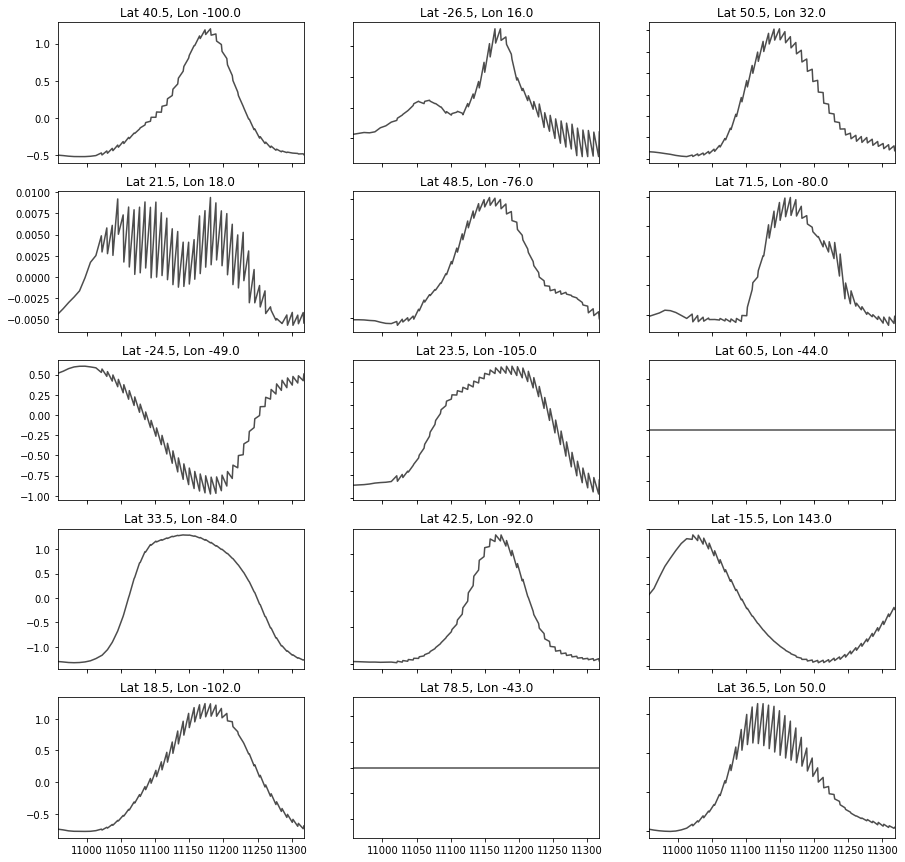

In [11]:
show_timeseries(LAI_ydaymean, color='#4d4d4d', ts=timestamps_ydaymean, reproduce=True)

### There is a problem here. When using ydaymean to obtain the multi-year averages, 84 and not 46 values are returned. Although the actual observed days are the same in every year, the multi-year mean is returned on a different index in leap years. For instance, March 25 is the 84th day in normal years, but the 85th day in leap years. Because there are much less leap years to calculate the multi-year average for the leap-year indexes, the resulting ydaymean is non-smooth. 

In [12]:
len(np.unique(pd.to_datetime(timestamps, unit='d').dayofyear))

46

In [13]:
len(np.unique(pd.to_datetime(timestamps_ydaymean, unit='d').dayofyear))

84

## 2.2 with [xarray](http://xarray.pydata.org/en/stable/)

![alt text](http://xarray.pydata.org/en/stable/_images/dataset-diagram-logo.png)

>**"xarray (formerly xray) is an open source project and Python package that aims to bring the labeled data power of pandas to the physical sciences, by providing N-dimensional variants of the core pandas data structures."**

In [14]:
import xarray as xr

In [15]:
ds = xr.open_dataset(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI_DETREND.nc'))

When grouping the observations by `dayofyear`, only 46 unique groups are created:

In [16]:
test = ds.groupby('time.dayofyear')
len(test.groups.keys())

46

As such, the multi-year daily mean can easily be obtained in pandas-style fashion:

In [17]:
ydaymean = ds.groupby('time.dayofyear').mean(dim='time')

In [18]:
def show_timeseries_xarr(xarr, color='#4d4d4d', reproduce=True, key='LAI'):
    """
    Randomly sample 15 pixels, plot LAI time series. 
    If a pixel with missing data is sampled, resample. 
    
    Arguments:
    ndarr: 3d ndarray from netcdf file
    ts: ndarray, unix timestamps
    reproduce: fix seed if True
    """
    
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
    if reproduce:
        rd.seed(42) # set seed to sample the same pixels everytime
    for axrow in axes:
        for ax in axrow:

            # choose random pixel, resample if it's a sea pixel
            i, j = rd.randint(0, xarr.dims['lat']-1), rd.randint(0, xarr.dims['lon']-1)
           
            while(np.all(xarr[key][:,i, j].isnull())):
                i, j = rd.randint(0, xarr.dims['lat']-1), rd.randint(0, ydaymean.dims['lon']-1)
            # plot image
            xarr[key][:, i, j].plot(ax=ax, color=color)
            # add title
            ax.set_title('Lat {}, Lon {}'.format(lat[i],lon[j]))

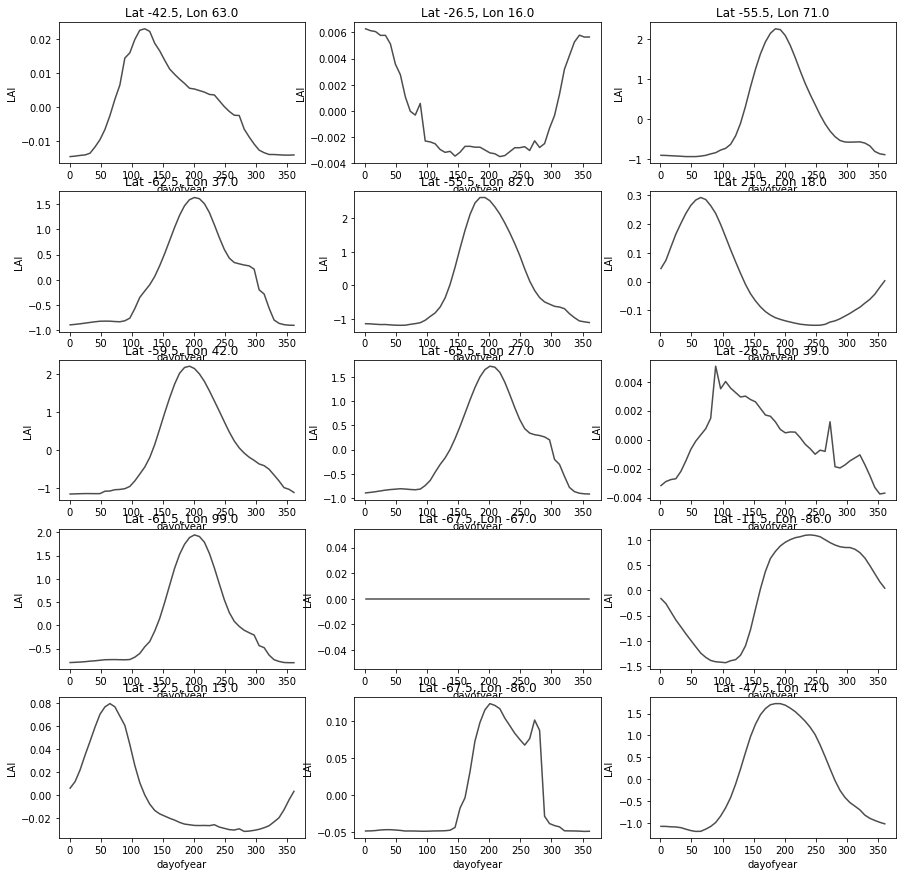

In [19]:
show_timeseries_xarr(ydaymean)

Looks better this time.

# 3. Calculate the residuals

Again some pandas magic to calculate the residuals:

In [20]:
resid = ds.groupby('time.dayofyear')-ydaymean


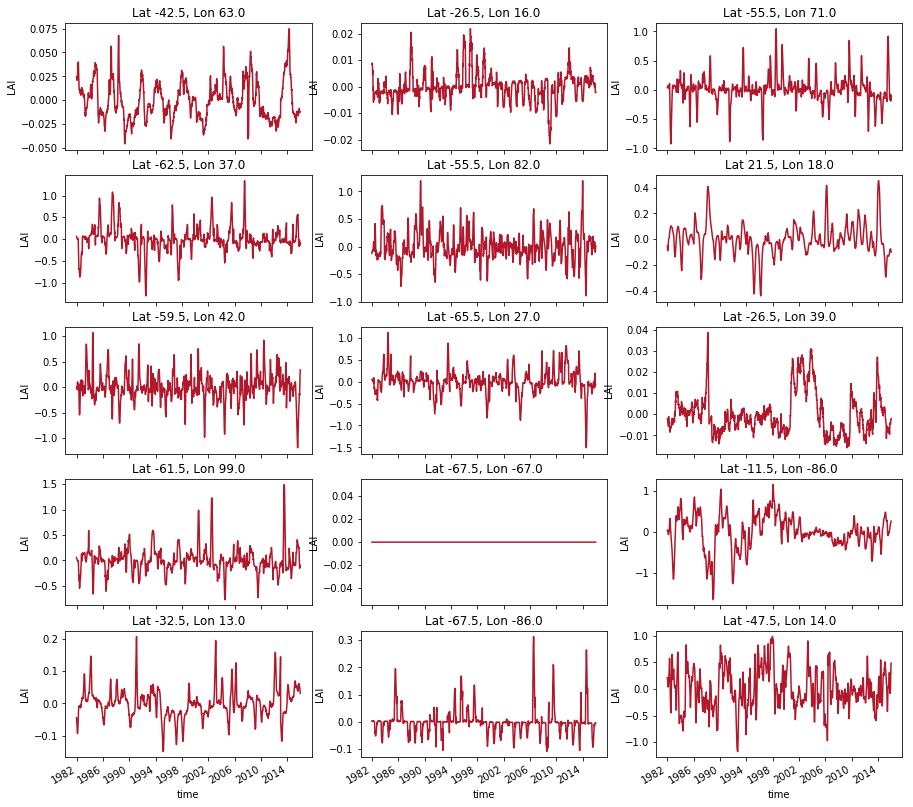

In [21]:
show_timeseries_xarr(resid, color='#b2182b' ,reproduce=True)

In [22]:
resid

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, time: 1564)
Coordinates:
  * lon        (lon) float64 -180.0 -179.0 -178.0 -177.0 -176.0 -175.0 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * time       (time) datetime64[ns] 1982-01-01 1982-01-09 1982-01-17 ...
    dayofyear  (time) int32 1 9 17 25 33 41 49 57 65 73 81 89 97 105 113 121 ...
Data variables:
    LAI        (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

**Publish as netcdf file:**

In [23]:
resid = resid.drop('dayofyear')

In [24]:
resid.to_netcdf(os.path.join(filepath, 'GLASSLAI2', 'GLASSLAI.AVHRR.V004.1982-2015_1_RESIDUALS.nc'))